# Projet 9 : Prédisez la demande en électricité 

## Scénario

**Prérequis**

Pour effectuer ce projet, vous devrez maîtriser la manipulation de données en Python ou R, connaître la modélisation de type régression linéaire, ainsi que les différentes modélisations de séries temporelles (AR, MA, ARMA, ARIMA, etc.)
<br><br>
**Mise en situation**

Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.

La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !


## Les données

Vous téléchargerez les données mensuelles de consommation totale d'électricité en énergie à partir de cette [page](https://www.rte-france.com/eco2mix/telecharger-les-indicateurs).

Les données météo que vous utiliserez pour corriger les données de l'effet température sont présentes ici : [https://cegibat.grdf.fr/simulateur/calcul-dju](https://cegibat.grdf.fr/simulateur/calcul-dju)

## Vos missions

Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

<ol><li>Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
<li>Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
<li>Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.</li></ol>

Pour chaque traitement effectué (correction de l'effet température, désaisonnalisation, etc.), vous présenterez les 2 séries temporelles avant et après traitement, sur un graphique où les deux séries temporelles seront superposées.

## Environnement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '../P9/P9_00_datasets/'

df = pd.read_csv(path + 'eCO2mix_RTE_energie_M.csv', sep=';')

## Mission 1

Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire

### Description et preprocessing

In [3]:
#before introducing my analysis, I provide a brief description of my data
df

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0,NaN
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0,NaN
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0,NaN
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0,NaN
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,2021-10,Données consolidées,Occitanie,1955,878.0,1,NaN,0,1,467,...,2750,-956.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386,2021-10,Données consolidées,Normandie,6514,6130.0,130,0.0,30,100,8,...,2124,4390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1387,2021-10,Données consolidées,Hauts-de-France,3690,1954.0,579,0.0,0,579,0,...,4100,-410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1388,2021-10,Données consolidées,PACA,966,NaN,309,0.0,17,292,419,...,2981,-2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#energy data (consolidated and final): they relate to France and the 12 administrative regions.
df = df[df['Territoire'] == 'France'].drop('Unnamed: 22', axis=1).reset_index(drop=True)

#brief data description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Mois                                      118 non-null    object 
 1   Qualité                                   118 non-null    object 
 2   Territoire                                118 non-null    object 
 3   Production totale                         118 non-null    int64  
 4   Production nucléaire                      118 non-null    float64
 5   Production thermique totale               118 non-null    int64  
 6   Production thermique charbon              118 non-null    float64
 7   Production thermique fioul                118 non-null    int64  
 8   Production thermique gaz                  118 non-null    int64  
 9   Production hydraulique                    118 non-null    int64  
 10  Production éolien                     

📌 [Description des données en énergie](https://assets.rte-france.com/prod/public/2020-07/éCO2mix%20-%20Description%20des%20fichiers%20des%20données%20en%20énergie.pdf)

Production totale et consommation totale en GWh

In [5]:
#keep only usefull columns
df = df[['Mois', 'Consommation totale']]

#converting the month column to date time format
df['Mois'] = df['Mois'].astype('datetime64[M]')

In [6]:
df.head()

,Mois,Consommation totale
0,2012-01-01,51086
1,2012-02-01,54476
2,2012-03-01,43156
3,2012-04-01,40176
4,2012-05-01,35257
...,...,...
113,2021-06-01,32031
114,2021-07-01,32957
115,2021-08-01,31169
116,2021-09-01,32349


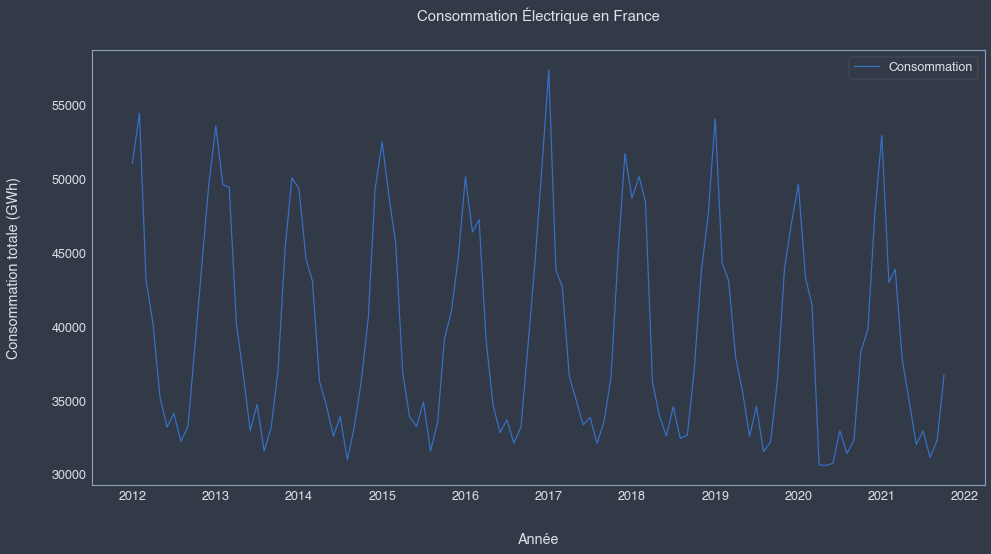

In [36]:
plt.figure(figsize=(16,8))

sns.lineplot(data=df, x='Mois', y='Consommation totale')

plt.xlabel('Année', labelpad=30)
plt.ylabel('Consommation totale (GWh)', labelpad=30)
plt.legend(labels=['Consommation'])
plt.title('Consommation Électrique en France', fontsize=15, pad=30)

plt.show()